In [1]:
import pandas as pd
import ast
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric, NeighborhoodComponentsAnalysis
from sklearn.decomposition import NMF, FactorAnalysis
from collections import defaultdict

/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../noFluffJobs/no_fluffs.csv')
df = df.drop('Unnamed: 0', axis=1)


def filter_tags(str_tag_list):
    tag_list = ast.literal_eval(str_tag_list)
    return [x.strip() for x in tag_list]


df['tag'] = df['Tags'].apply(filter_tags)
df.head()

,Role,Tags,Additional,tag
0,React Frontend Developer,"[' React', ' JavaScript', ' CSS', ' Git', ' RE...","{' Job profile ': ' Mainly new features ', ' S...","[React, JavaScript, CSS, Git, REST, html5, nod..."
1,C++ Engineer,"[' C++', ' Linux', ' STL', ' Boost', ' unit te...","{' Job profile ': ' Mainly new features ', ' S...","[C++, Linux, STL, Boost, unit test, Jenkins, d..."
2,Front End Developer,"[' Angular', ' JavaScript', ' CSS', ' HTML', '...","{' Job profile ': ' Mainly new features ', ' S...","[Angular, JavaScript, CSS, HTML, React, Design..."
3,Frontend Developer,"[' JavaScript', ' jQuery', ' Angular', ' CSS',...","{' Job profile ': ' Mainly new features ', ' S...","[JavaScript, jQuery, Angular, CSS, HTML, redux..."
4,Python Developer,"[' Python', ' Django', ' PostgreSQL', ' experi...","{' Start ': ' 2020-05-01 ', ' Contract duratio...","[Python, Django, PostgreSQL, experience in dev..."


In [15]:
df['Additional'].iloc[300]

"{' Start ': ' ASAP ', ' Contract duration ': ' Permanent contract ', ' Paid holiday ': ' B2B - No  +1 ', ' Part time work ': ' No ', ' Remote possible ': ' Yes (1 day a week) ', ' Flexible hours ': ' No ', ' Travel involved ': ' No ', ' Freedom to choose tools ': ' Yes '}"

## Create the adjacency matrix

See which tags are coocurring

In [19]:
tag_dict = defaultdict(list)
all_tags = df['tag'].tolist()

flat_tags = [tag for tag_list in all_tags for tag in tag_list]
flat_tag_dict = {tag: i for i, tag in enumerate(flat_tags)}
inverted_tag_dict = {i: tag for i, tag in enumerate(flat_tags)}
vectors = np.zeros(shape=(len(all_tags), len(flat_tags)), dtype=np.uint16)
tag_matrix = np.zeros(shape=(len(flat_tags), len(flat_tags)), dtype=np.uint16)

for k, tag_list in enumerate(all_tags):
    for i in range(len(tag_list)):
        i_tag = flat_tag_dict[tag_list[i]]
        vectors[k][i] = 1
        for j in range(len(tag_list)):
            if i == j:
                continue
            j_tag = flat_tag_dict[tag_list[j]]
            tag_matrix[i_tag, j_tag] += 1
            tag_matrix[j_tag, i_tag] += 1

In [17]:
metrics_matrix = 1.0/tag_matrix.astype(np.float32)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [18]:
metrics_matrix[np.isinf(metrics_matrix)] = 9999.99
metrics_matrix

array([[9.9999902e+03, 9.9999902e+03, 9.9999902e+03, ..., 9.9999902e+03,
        9.9999902e+03, 9.9999902e+03],
       [9.9999902e+03, 9.9999902e+03, 9.9999902e+03, ..., 9.9999902e+03,
        9.9999902e+03, 9.9999902e+03],
       [9.9999902e+03, 9.9999902e+03, 9.9999902e+03, ..., 9.9999902e+03,
        9.9999902e+03, 9.9999902e+03],
       ...,
       [9.9999902e+03, 9.9999902e+03, 9.9999902e+03, ..., 9.9999902e+03,
        5.1020407e-03, 1.0000000e-01],
       [9.9999902e+03, 9.9999902e+03, 9.9999902e+03, ..., 5.1020407e-03,
        2.5000000e-01, 1.2500000e-01],
       [9.9999902e+03, 9.9999902e+03, 9.9999902e+03, ..., 1.0000000e-01,
        1.2500000e-01, 9.9999902e+03]], dtype=float32)

In [5]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, 
          dissimilarity='precomputed',
          n_jobs=-1)

X_embeds = mds.fit_transform(tag_matrix)

In [68]:
size = 5
random_skills = np.random.choice(flat_tags, size=size)

random_skill_indices = [flat_tag_dict[sk] 
                       for sk in random_skills]


def find_N_coorcuring(matrix, tag_id, size=5):
    """
    Returns the indices and the values 
    """
    skill_indices_n = matrix[tag_id, :].argsort()[::-1][:size]
    skill_vals = matrix[tag_id, skill_indices_n]
    return skill_indices_n, skill_vals


for i in range(len(random_skills)):
    skill_inds, vals = find_N_coorcuring(tag_matrix,
                                        random_skill_indices[i])
    coocs = [inverted_tag_dict[k] for k in skill_inds]
    print(f"Skill {random_skills[i]}")
    print(f"\tCoocs:{coocs}")
    print(f"\tVals: {vals}")

Skill MySQL
	Coocs:['Git', 'English', 'PHP', 'Problem solving', 'Communication skills']
	Vals: [122 114 104  86  80]
Skill Hibernate
	Coocs:['Java', 'Spring', 'English', 'Git', 'REST']
	Vals: [184 168 130 116 108]
Skill High Scalability
	Coocs:['Clean Code', 'Jenkins', 'Polish', 'High Availability', 'Scalability']
	Vals: [4 4 4 4 4]
Skill Team player
	Coocs:['English', 'Communication skills', 'Problem solving', 'Proactivity', 'Git']
	Vals: [826 746 666 494 420]
Skill Linux
	Coocs:['English', 'Git', 'Docker', 'Communication skills', 'Python']
	Vals: [324 232 220 208 198]


For a searched skill find N most coocuring 
and then compose matrix of size (N+1, N+1) containing the coocurences of all those skills

In [73]:
import itertools
size = 5
random_skill = np.random.choice(flat_tags, size=1)
random_skill_index = flat_tag_dict[random_skill[0]]

rs_coocs, rs_vals = find_N_coorcuring(tag_matrix, random_skill_index)
r_names = [inverted_tag_dict[index] for index in rs_coocs]
all_names = r_names + random_skill.tolist()
p_color_matrix = np.zeros(shape=(size+1, size+1))

# 2 - pairwise combinations, no replacement
label_indices = {tag: i for i, tag in enumerate(all_names)}
for com in itertools.combinations(r_names, r=2):
    l1, l2 = com 
    i1, i2 = label_indices[l1], label_indices[l2]
    j1, j2 = flat_tag_dict[l1], flat_tag_dict[l2]

    p_color_matrix[i1, i2] = tag_matrix[j1, j2]
    p_color_matrix[i2, i1] = tag_matrix[j1, j2]

In [74]:
p_color_matrix

array([[  0., 306., 484., 328., 282.,   0.],
       [306.,   0., 214., 174., 160.,   0.],
       [484., 214.,   0., 674., 466.,   0.],
       [328., 174., 674.,   0., 420.,   0.],
       [282., 160., 466., 420.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]])

In [77]:
print(r_names, len(r_names))

['Java', 'Spring', 'English', 'Git', 'REST'] 5


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


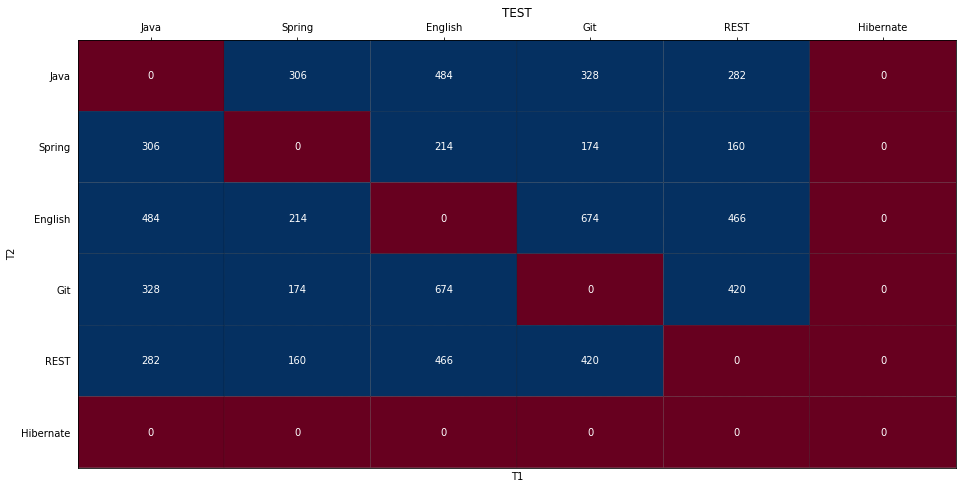

In [101]:
heatmap(p_color_matrix, "TEST", "T1", "T2", all_names, all_names)

In [100]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC,
                  edgecolors='k',
                  linestyle='dashed',
                  linewidths=0.2,
                  cmap='RdBu',
                  vmin=0.0,
                  vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim((0, AUC.shape[1]))

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    # Add color bar
#     plt.colorbar(c)

    # Add text in each cell

    for y in range(AUC.shape[0]):
        for x in range(AUC.shape[1]):
            plt.text(
                x + 0.5,
                y + 0.5,
                int(AUC[y, x]),
                horizontalalignment='center',
                verticalalignment='center',
                color='white'
            )

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))